In this notebook we split dataset to train and testset. This basic task is done to ensure that we use the same dataset in all trainings. This is done, on the other hand, to ensure that we can probebly analyse results and do case studies.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
import datetime as dt
import boto3, yaml
from datetime import timedelta

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize, MinMaxScaler
from imblearn.over_sampling import SMOTE
import sys,os
util_path = os.path.abspath(os.path.join(os.path.pardir, '../sasse-polygon-process/lib'))
if util_path not in sys.path and os.path.exists(util_path):
    sys.path.insert(0, util_path)
    
from config import read_options

sns.set()
sns.set_style("whitegrid")
%matplotlib inline

Using TensorFlow backend.


In [12]:
class Options(): pass

options = Options()
options.config_filename = '../cnf/rfc.ini'
options.config_name = 'forest'
read_options(options)

options_thin = Options()
options_thin.config_filename = '../cnf/rfc.ini'
options_thin.config_name = 'thin'
read_options(options_thin)

In [85]:
def get_data(name, options, size=None, balance=False, cherry_pick=None, max_size=None, scaler=None, verbose=False):
    """ Read and normalise data """
    
    data = pd.read_csv(name)
    data = data.loc[data['weather_parameter'] == 'WindGust'].fillna(0)

    label = options.label[0]
    
    if size is None:
        y = data.loc[:, options.label].values.ravel()
        data_train, data_test, _, __ = train_test_split(data, y, stratify=y)        
    else:   
        
#        if balance:
            
#            count = data.groupby(label).size().min()
#            data = pd.concat([data.loc[data[label] == 0].sample(n=count), data.loc[data[label] == 1].sample(n=count)])

        if cherry_pick is not None and size[0] < 1 and size[1] < 1:
            # Classes which are not cherry-picked
            classes = list(data.loc[:, label].unique())
            not_cherry_picked = list(set(classes) - set(cherry_pick))
            random_data = data.loc[data.loc[:,label].isin(not_cherry_picked),:]
            random_y = random_data.loc[:, label].values.ravel()
            data_train, data_test, _, __ = train_test_split(random_data, random_y, train_size=size[0], test_size=size[1], stratify=random_y)

            # Cherry picked classes
            picked_data = data.loc[data.loc[:,label].isin(classes),:]
            picked_data_train, picked_data_test = train_test_split(picked_data, train_size=size[0], test_size=size[1])
            
            # Concat
            data_train = pd.concat([data_train, picked_data_train])
            data_test = pd.concat([data_test, picked_data_test])                        
        else:            
            y = data.loc[:, options.label].values.ravel()        
            data_train, data_test, _, __ = train_test_split(data, y, train_size=size[0], test_size=size[1], stratify=y)

            
    # Cut all classes to max size
    if max_size is not None:
        dfs = []
        for c in list(data_train.loc[:, label].unique()):
            dfs.append(data_train.loc[(data[label] == c),:].reset_index(drop=True).iloc[0:max_size,:])
        data_train = pd.concat(dfs)
            
    # For analysis
    if verbose:
        for c in [1,2,3]:
            print('Dates in testset class {}:'.format(c))
            for i, row in data_test[(data_test['class']==c)].iterrows():
                print(row.point_in_time, end=',')
    
    X_train = data_train.loc[:, options.feature_params]
    y_train = data_train.loc[:, options.label]
    meta_train = data_train.loc[:, options.meta_params]

    X_test = data_test.loc[:, options.feature_params]
    y_test = data_test.loc[:, options.label]
    meta_test = data_test.loc[:, options.meta_params]
    
    if scaler is None:
        scaler = StandardScaler()
        
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=options.feature_params)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=options.feature_params)
    
    sm = SMOTE()
    X_res, y_res = sm.fit_resample(X_train, y_train)
    
    train = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True), meta_train.reset_index(drop=True)], axis=1)
    test = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True), meta_test.reset_index(drop=True)], axis=1)
    res = pd.concat([pd.DataFrame(X_res, columns=options.feature_params), pd.DataFrame(y_res, columns=options.label)], axis=1)
    
    return train, test, res

In [81]:
def plot_class_hist(data_train, data_test,title='', num_classes=4, fontsize=10):

    fig, ax = plt.subplots(figsize=(15,4))
    plt.rc('font', size=fontsize)
    tickfontsize=0.8*fontsize
    
    ##### Plot 1
    ax = plt.subplot(1,2,1)

    data_train.loc[:, 'class'].hist(ax=ax, color='xkcd:tea')

    ymin, ymax = ax.get_ylim()
    ax.set_ylim((ymin, ymax*1.1))
    
    plt.title('Train set', fontsize=fontsize)
    plt.ylabel('Record count', fontsize=fontsize)
    plt.xlabel('Class', fontsize=fontsize)
    plt.yticks(fontsize=tickfontsize)
    plt.xticks(fontsize=tickfontsize)

    i=0
    for rect in ax.patches:
        if i%(num_classes-1) == 0:
            height = rect.get_height()
            ax.annotate(f'{int(height)}', xy=(rect.get_x()+rect.get_width()/2, height), 
                        xytext=(0, 5), textcoords='offset points', ha='center', va='bottom') 
        i+=1
    
    plt.grid(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    ##### Plot 2 
    
    ax = plt.subplot(1,2,2)
    data_test.loc[:, 'class'].hist(ax=ax, color='xkcd:dust')    
    
    ymin, ymax = ax.get_ylim()
    ax.set_ylim((ymin, ymax*1.1))
    
    plt.grid(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.title('Test set', fontsize=fontsize)
    plt.ylabel('Record count', fontsize=fontsize)
    plt.xlabel('Class', fontsize=fontsize)
    plt.yticks(fontsize=tickfontsize)
    plt.xticks(fontsize=tickfontsize)
    
    i=0
    for rect in ax.patches:
        if i%(num_classes-1) == 0:
            height = rect.get_height()
            ax.annotate(f'{int(height)}', xy=(rect.get_x()+rect.get_width()/2, height), 
                        xytext=(0, 5), textcoords='offset points', ha='center', va='bottom') 
        i+=1
    
    plt.suptitle(title, x=.22, y=1.03)

In [83]:
def save_dataset(datasets):
    """ Save data to local filesystem and S3 """
    
    for name, data in datasets:
        filename = '../data/{}.csv'.format(name)
        remote_name = 'data/{}.csv'.format(name)

        data.to_csv(filename, index=False)
        
        s3 = boto3.resource('s3')
        s3.meta.client.upload_file(filename, 'fmi-asi-sasse-assets', remote_name)

# Loiste - JSE

In [86]:
print('All params:')
train_all_loiste, test_all_loiste, res_all_loiste = get_data('../data/classification_dataset_jse_forest.csv', options, verbose=True)

print('Thin setup:')
train_thin_loiste, test_thin_loiste, res_thin_loiste = get_data('../data/classification_dataset_loiste_jse_forest.csv', options_thin, verbose=True)

print('Small set with all params:')
train_small_loiste, test_small_loiste, res_small_loiste = get_data('../data/classification_dataset_loiste_jse_forest.csv', options, (.8, .2), cherry_pick=[1,2,3], max_size=1000, verbose=True)

print('Tiny set with all params:')
train_tiny_loiste, test_tiny_loiste, res_tiny_loiste = get_data('../data/classification_dataset_loiste_jse_forest.csv', options, (.8, .2), cherry_pick=[1,2,3], max_size=500, verbose=True)

All params:
Dates in testset class 1:
2018-06-04 21:00:00+00,2015-06-03 07:00:00+00,2014-09-24 18:00:00+00,2011-12-02 04:00:00+00,2012-11-30 07:00:00+00,2010-10-12 05:00:00+00,2017-06-30 12:00:00+00,2014-09-23 07:00:00+00,2018-09-27 12:00:00+00,2011-03-24 14:00:00+00,2018-06-30 04:00:00+00,2012-05-14 12:00:00+00,2012-02-06 07:00:00+00,2012-11-30 12:00:00+00,2013-11-17 06:00:00+00,2016-09-30 11:00:00+00,2016-06-09 07:00:00+00,2015-04-10 16:00:00+00,2012-09-17 17:00:00+00,2010-07-22 18:00:00+00,2018-06-23 01:00:00+00,2011-12-02 03:00:00+00,2011-12-02 00:00:00+00,2011-11-30 14:00:00+00,2014-03-14 06:00:00+00,2011-12-27 16:00:00+00,2018-10-22 00:00:00+00,2018-09-20 09:00:00+00,2014-05-14 08:00:00+00,2016-12-05 06:00:00+00,2018-07-01 12:00:00+00,2012-06-18 03:00:00+00,2011-12-09 22:00:00+00,2018-06-23 00:00:00+00,2011-03-10 12:00:00+00,2015-12-11 02:00:00+00,2012-02-06 06:00:00+00,2011-05-19 18:00:00+00,2011-09-27 12:00:00+00,2013-10-13 09:00:00+00,2012-02-06 14:00:00+00,2018-09-27 09:00:00

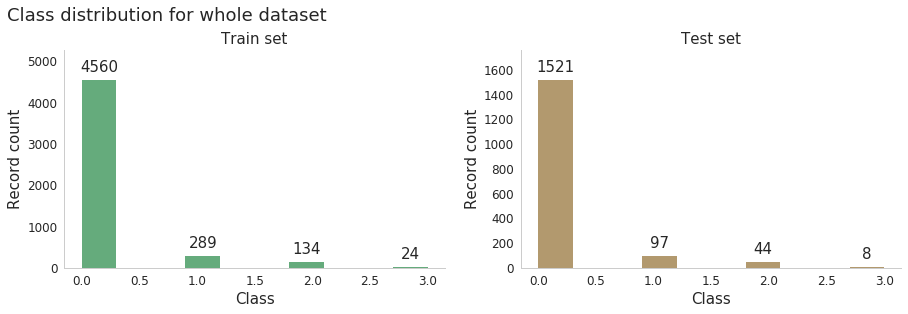

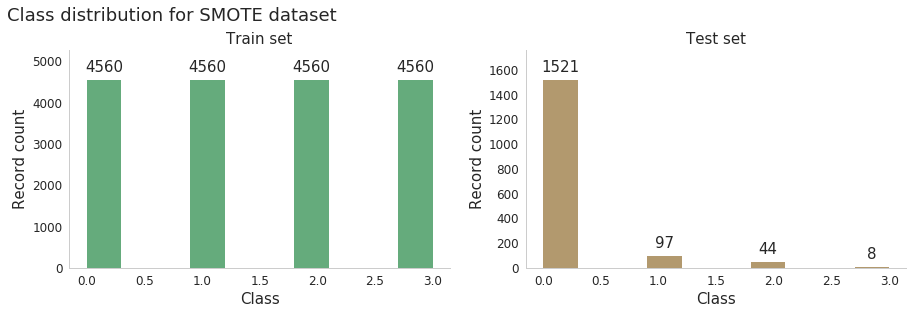

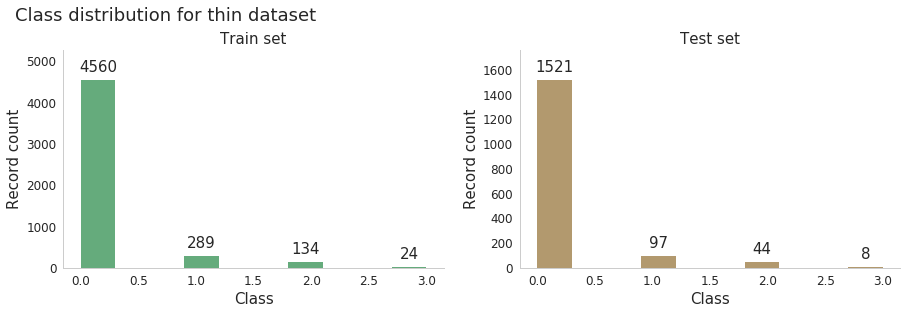

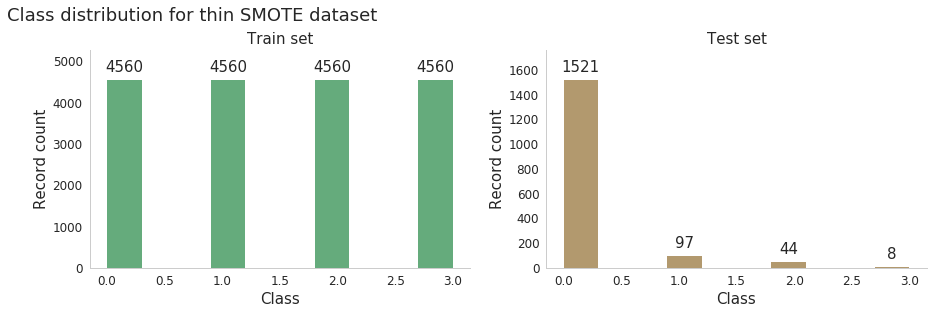

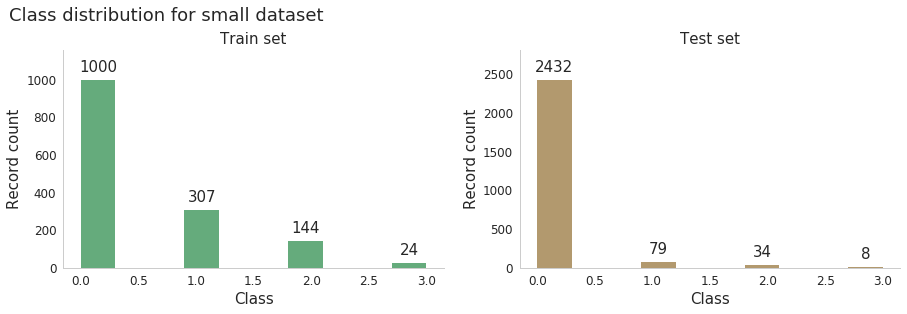

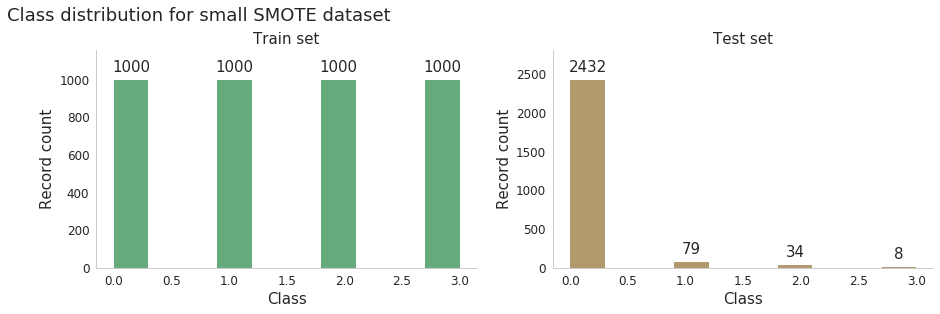

In [87]:
plot_class_hist(train_all_loiste, test_all_loiste, title='Class distribution for whole dataset', fontsize=15)
plot_class_hist(res_all_loiste, test_all_loiste, title='Class distribution for SMOTE dataset', fontsize=15)

plot_class_hist(train_thin_loiste, test_thin_loiste, title='Class distribution for thin dataset', fontsize=15)
plot_class_hist(res_thin_loiste, test_thin_loiste, title='Class distribution for thin SMOTE dataset', fontsize=15)

plot_class_hist(train_small_loiste, test_small_loiste, title='Class distribution for small dataset', fontsize=15)
plot_class_hist(res_small_loiste, test_small_loiste, title='Class distribution for small SMOTE dataset', fontsize=15)

In [92]:
datasets = [('loiste_jse_all_train', train_all_loiste), 
            ('loiste_jse_all_test', test_all_loiste), 
            ('loiste_jse_all_res', res_all_loiste),
            ('loiste_jse_thin_train', train_thin_loiste),
            ('loiste_jse_thin_test', test_thin_loiste),
            ('loiste_jse_thin_res', res_thin_loiste),
            ('loiste_jse_small_train', train_small_loiste),
            ('loiste_jse_small_test', test_small_loiste),
            ('loiste_jse_small_res', res_small_loiste),
            ('loiste_jse_tiny_train', train_tiny_loiste),
            ('loiste_jse_tiny_test', test_tiny_loiste),
            ('loiste_jse_tiny_res', res_tiny_loiste)
           ]
save_dataset(datasets)


# Energiateollisuus

In [101]:
class Options(): pass

options_ene = Options()
options_ene.config_filename = '../cnf/rfc.ini'
options_ene.config_name = 'forest_energiateollisuus'
read_options(options_ene)

options_ene_thin = Options()
options_ene_thin.config_filename = '../cnf/rfc.ini'
options_ene_thin.config_name = 'thin_energiateollisuus'
read_options(options_ene_thin)

In [104]:
print('All params:')
train_all_energiateollisuus, test_all_energiateollisuus, res_all_energiateollisuus = get_data('../data/classification_dataset_energiateollisuus_forest.csv', options_ene, verbose=True)

print('Thin setup:')
train_thin_energiateollisuus, test_thin_energiateollisuus, res_thin_energiateollisuus = get_data('../data/classification_dataset_energiateollisuus_forest.csv', options_ene_thin, verbose=True)

print('Small set with all params:')
train_small_energiateollisuus, test_small_energiateollisuus, res_small_energiateollisuus = get_data('../data/classification_dataset_energiateollisuus_forest.csv', options_ene, (.8, .2), cherry_pick=[1,2,3], max_size=1000, verbose=True)

print('Tiny set with all params:')
train_tiny_energiateollisuus, test_tiny_energiateollisuus, res_tiny_energiateollisuus = get_data('../data/classification_dataset_energiateollisuus_forest.csv', options_ene, (.8, .2), cherry_pick=[1,2,3], max_size=500, verbose=True)

All params:
Dates in testset class 1:
2015-06-16 13:00:00+00,2016-12-29 09:00:00+00,2015-04-23 04:00:00+00,2017-04-29 14:00:00+00,2016-12-25 20:00:00+00,2015-04-29 08:00:00+00,2016-12-09 11:00:00+00,2015-04-14 11:00:00+00,2016-10-09 09:00:00+00,2018-01-15 22:00:00+00,2018-08-10 08:00:00+00,2017-01-11 05:00:00+00,2017-09-03 17:00:00+00,2018-10-30 09:00:00+00,2016-12-30 18:00:00+00,2016-11-24 14:00:00+00,2016-01-30 18:00:00+00,2018-08-09 15:00:00+00,2017-10-28 13:00:00+00,2017-04-26 10:00:00+00,2016-11-15 14:00:00+00,2017-07-05 13:00:00+00,2016-03-17 07:00:00+00,2015-01-15 16:00:00+00,2015-06-01 10:00:00+00,2016-09-01 06:00:00+00,2018-06-18 14:00:00+00,2018-10-31 18:00:00+00,2018-09-27 07:00:00+00,2017-12-08 08:00:00+00,2016-08-08 12:00:00+00,2018-01-24 04:00:00+00,2018-06-04 16:00:00+00,2018-09-23 13:00:00+00,2017-12-14 10:00:00+00,2018-05-18 15:00:00+00,2018-09-20 06:00:00+00,2018-03-15 09:00:00+00,2016-11-08 12:00:00+00,2017-01-20 11:00:00+00,2016-08-29 07:00:00+00,2018-09-22 15:00:00

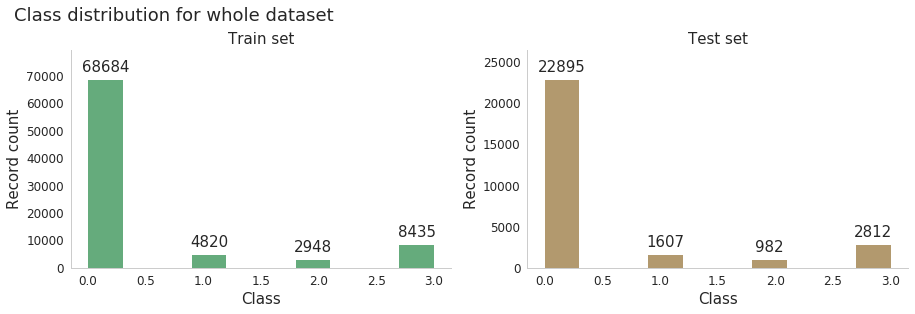

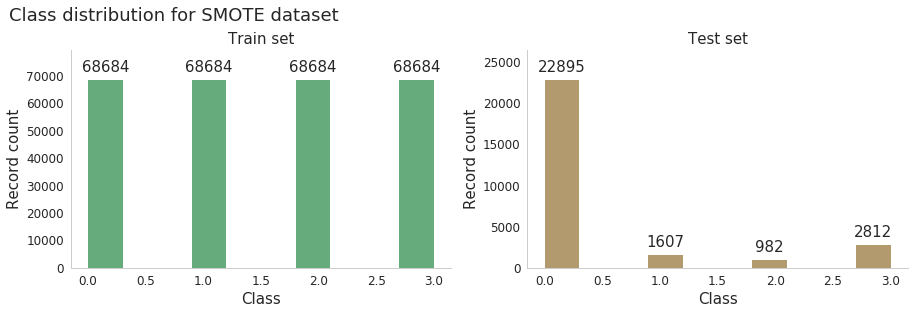

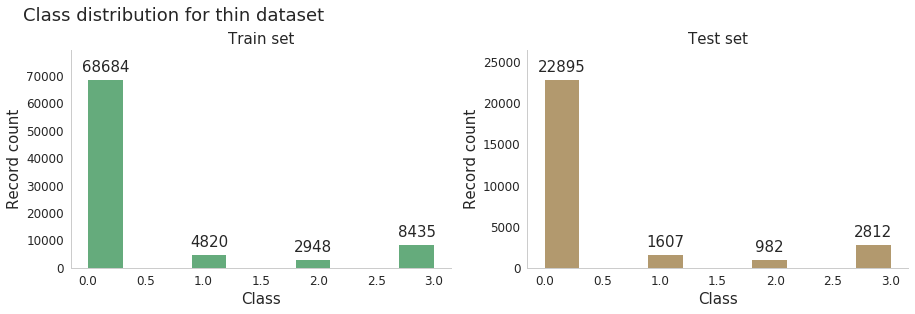

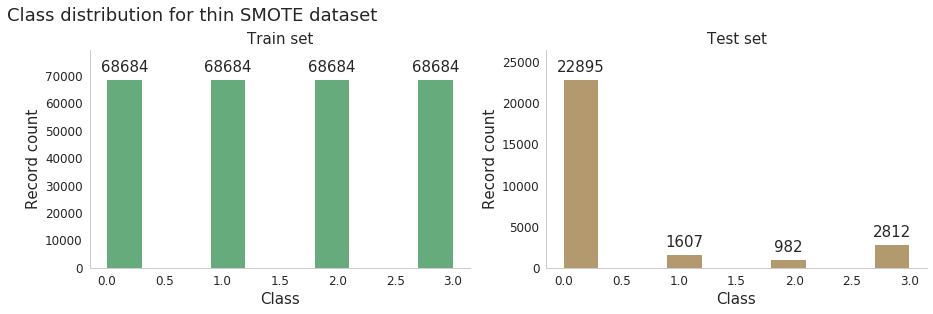

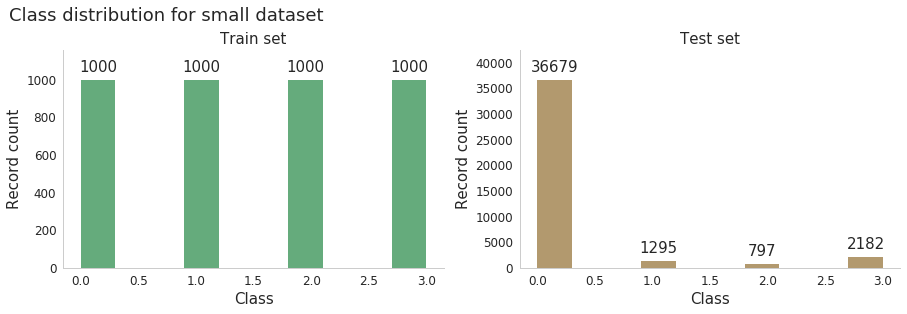

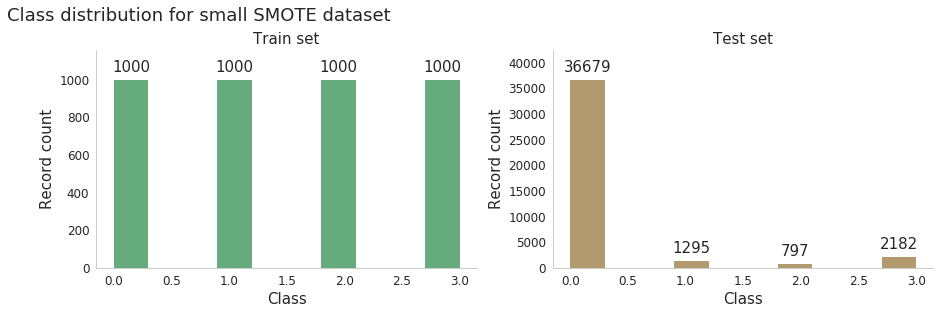

In [105]:
plot_class_hist(train_all_energiateollisuus, test_all_energiateollisuus, title='Class distribution for whole dataset', fontsize=15)
plot_class_hist(res_all_energiateollisuus, test_all_energiateollisuus, title='Class distribution for SMOTE dataset', fontsize=15)

plot_class_hist(train_thin_energiateollisuus, test_thin_energiateollisuus, title='Class distribution for thin dataset', fontsize=15)
plot_class_hist(res_thin_energiateollisuus, test_thin_energiateollisuus, title='Class distribution for thin SMOTE dataset', fontsize=15)

plot_class_hist(train_small_energiateollisuus, test_small_energiateollisuus, title='Class distribution for small dataset', fontsize=15)
plot_class_hist(res_small_energiateollisuus, test_small_energiateollisuus, title='Class distribution for small SMOTE dataset', fontsize=15)

In [106]:
datasets = [('energiateollisuus_all_train', train_all_energiateollisuus), 
            ('energiateollisuus_all_test', test_all_energiateollisuus), 
            ('energiateollisuus_all_res', res_all_energiateollisuus),
            ('energiateollisuus_thin_train', train_thin_energiateollisuus),
            ('energiateollisuus_thin_test', test_thin_energiateollisuus),
            ('energiateollisuus_thin_res', res_thin_energiateollisuus),
            ('energiateollisuus_small_train', train_small_energiateollisuus),
            ('energiateollisuus_small_test', test_small_energiateollisuus),
            ('energiateollisuus_small_res', res_small_energiateollisuus),
            ('energiateollisuus_tiny_train', train_tiny_energiateollisuus),
            ('energiateollisuus_tiny_test', test_tiny_energiateollisuus),
            ('energiateollisuus_tiny_res', res_tiny_energiateollisuus)
           ]
save_dataset(datasets)